In [1]:
#라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 로드
df = pd.read_csv('05_merged_dataset.csv')

# 결측치 제거 및 클러스터링 대상 피처(premium_ratio) 추출
df_clean = df.dropna(subset=['premium_ratio']).copy()
X_cluster = df_clean[['premium_ratio']]

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print(f"분석 대상 데이터 수: {len(X_scaled)}개\n")

분석 대상 데이터 수: 165139개



## step1. 최적의 K 찾기

In [3]:
# 평가할 K의 범위 : k의 범위를 2에서 6까지 한정
k_range = range(2, 7)
inertias = []
silhouette_scores = []

for k in k_range:
    # K-Means 모델 학습
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    # 관성 계산: Elbow Method용
    inertias.append(kmeans.inertia_)
    
    # 실루엣 점수 계산
    score = silhouette_score(X_scaled, labels, sample_size=5000, random_state=42)
    silhouette_scores.append(score)
    
    print(f"   ▶ [K={k}] 일때 실루엣 점수: {score:.4f}")

   ▶ [K=2] 일때 실루엣 점수: 0.9034
   ▶ [K=3] 일때 실루엣 점수: 0.7129
   ▶ [K=4] 일때 실루엣 점수: 0.6176
   ▶ [K=5] 일때 실루엣 점수: 0.5947
   ▶ [K=6] 일때 실루엣 점수: 0.5788


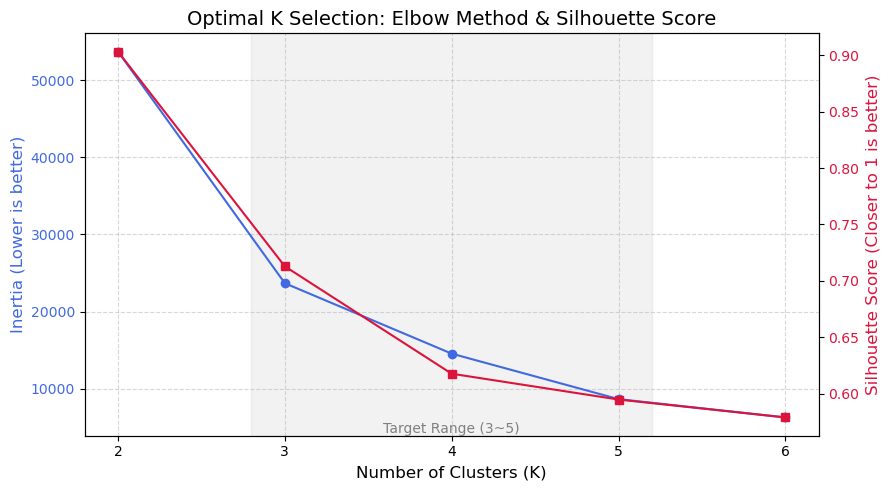

In [4]:
# 결과 시각화 
fig, ax1 = plt.subplots(figsize=(9, 5))

# 관성(Inertia) 그래프 (파란색)
ax1.plot(k_range, inertias, marker='o', color='royalblue', label='Inertia (Elbow)')
ax1.set_xlabel('Number of Clusters (K)', fontsize=12)
ax1.set_ylabel('Inertia (Lower is better)', color='royalblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.set_xticks(k_range)
ax1.grid(True, linestyle='--', alpha=0.5)

# 실루엣 점수 그래프 (빨간색)
ax2 = ax1.twinx()
ax2.plot(k_range, silhouette_scores, marker='s', color='crimson', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score (Closer to 1 is better)', color='crimson', fontsize=12)
ax2.tick_params(axis='y', labelcolor='crimson')

# 목표 범위(3~5) 시각적 강조
ax1.axvspan(2.8, 5.2, color='gray', alpha=0.1)
plt.text(4, ax2.get_ylim()[0], 'Target Range (3~5)', ha='center', va='bottom', color='gray', fontsize=10)

plt.title('Optimal K Selection: Elbow Method & Silhouette Score', fontsize=14)
fig.tight_layout()
plt.show()

## step2.최적의 K에 맞춘 k-means 실행 및 모델 학습

In [5]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold
import warnings
warnings.filterwarnings('ignore')

In [6]:
# 데이터 로드 및 파생 변수 생성
df = pd.read_csv('05_merged_dataset.csv')
df_clean = df.dropna(subset=['premium_ratio']).copy()

#  모델 편향 방지 위해 관심도 효율 및 발매가 로그 변환
df_clean['wish_efficiency'] = df_clean['wish_count'] / (df_clean['release_price'] + 1)
df_clean['log_release_price'] = np.log1p(df_clean['release_price'])

# K-Means 라벨링 (K=5)
scaler = StandardScaler()
premium_scaled = scaler.fit_transform(df_clean[['premium_ratio']])
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_clean['premium_lable'] = kmeans.fit_predict(premium_scaled)

# 라벨 정렬 (0:하락 ~ 4:폭등)
# 0 : 나중에 가격이 하락할 것으로 예상됨
# 1 : 이후에 가격 유지 또는 미세한 상승이 예상됨
# 2 : 이후 가격이 점점 오를 것으로 예상됨. (지금 사는 것이 좋다)
# 3 : 이미 가격이 올라있고, 더 오를 것으로 예상됨.
# 4 : 한정판 중에서도 더 구하기 힘든 한정판, 공급이 적어 라벨 3보다 가격 상승폭이 큼. 

order = df_clean.groupby('premium_lable')['premium_ratio'].mean().sort_values().index
mapping = {old: new for new, old in enumerate(order)}
df_clean['premium_lable'] = df_clean['premium_lable'].map(mapping)

# 데이터 분할 (Train / Test Split)
drop_cols = ['product_id', 'first_trade_date', 'trade_date', 'release_date', 
             'current_price', 'premium_ratio', 'premium_lable']
X = df_clean.drop(columns=drop_cols)
y = df_clean['premium_lable']
groups = df_clean['product_id']

# 제품 단위로 분리 
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# 가중치 및 튜닝 적용
class_weights = {0: 1, 1: 3, 2: 7, 3: 25, 4: 150}
sample_weights = np.array([class_weights[label] for label in y_train])

xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=10,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    tree_method='hist'
)


In [7]:
# GroupKFold 적용 
gkf = GroupKFold(n_splits=5)
cv_scores = []
groups_train = df_clean.iloc[train_idx]['product_id'] # 그룹 정보 추출

for fold, (t_idx, v_idx) in enumerate(gkf.split(X_train, y_train, groups=groups_train), 1):
    X_tr, X_val = X_train.iloc[t_idx], X_train.iloc[v_idx]
    y_tr, y_val = y_train.iloc[t_idx], y_train.iloc[v_idx]
    
    fold_model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
    fold_model.fit(X_tr, y_tr)
    
    acc = accuracy_score(y_val, fold_model.predict(X_val))
    cv_scores.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.4f}")

print(f"\n평균 검증 정확도: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

# 전체 Train 데이터로 최종 모델 학습 
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)


Fold 1 Accuracy: 0.5739
Fold 2 Accuracy: 0.5571
Fold 3 Accuracy: 0.5906
Fold 4 Accuracy: 0.6888
Fold 5 Accuracy: 0.6360

평균 검증 정확도: 0.6093 (+/- 0.0477)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [8]:
# Test dataset 추출 (확인용) 
test_data = df_clean.iloc[test_idx]
test_product_ids = test_data['product_id'].unique()

print(f" 테스트 세트에 사용된 고유 상품 수: {len(test_product_ids)}개")
print("테스트 상품 번호 : ")
print(test_product_ids[:24]) 

 테스트 세트에 사용된 고유 상품 수: 23개
테스트 상품 번호 : 
[    36 368908 783522 138416 282500 402232 526264 611602 611603  18402
  23879  24137  28029 612674  65219 643434 441846 751978 309629 542407
 547201 555990 748535]


## Step3. testset 적용 및 결과 시각화

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     23861
           1       0.62      0.61      0.62     11028
           2       0.76      0.64      0.70      3685
           3       0.00      0.00      0.00      1352
           4       0.00      0.00      0.00         6

    accuracy                           0.77     39932
   macro avg       0.44      0.43      0.44     39932
weighted avg       0.74      0.77      0.76     39932



Text(195.72222222222223, 0.5, 'Actual Label (Real Market)')

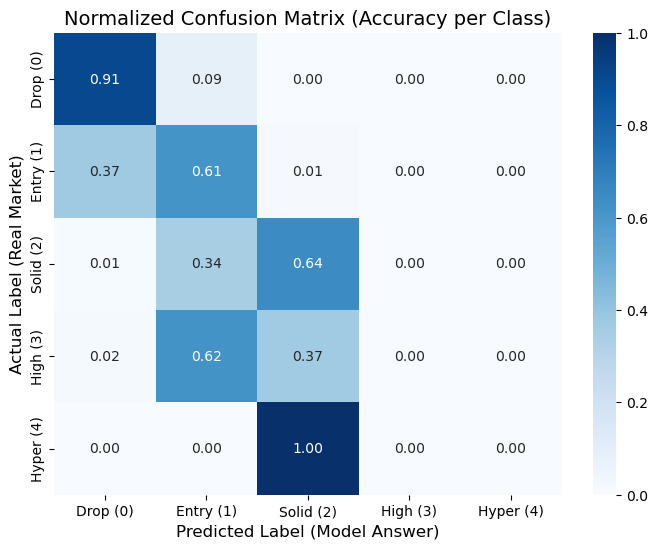

In [11]:
# 결과 시각화 
plt.figure(figsize=(18, 6))

# Normalized Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
cm_ratio = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
cm_ratio = np.nan_to_num(cm_ratio) 

sns.heatmap(cm_ratio, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Drop (0)', 'Entry (1)', 'Solid (2)', 'High (3)', 'Hyper (4)'],
            yticklabels=['Drop (0)', 'Entry (1)', 'Solid (2)', 'High (3)', 'Hyper (4)'])
plt.title('Normalized Confusion Matrix (Accuracy per Class)', fontsize=14)
plt.xlabel('Predicted Label (Model Answer)', fontsize=12)
plt.ylabel('Actual Label (Real Market)', fontsize=12)


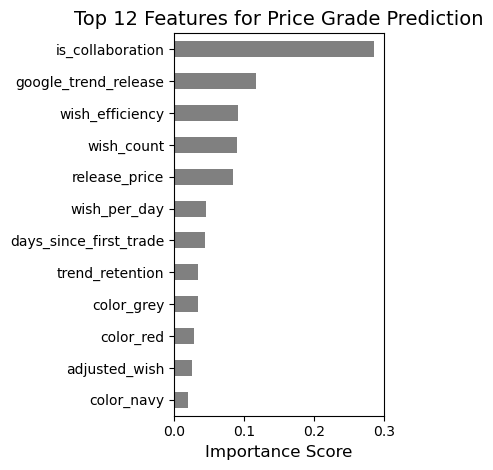

In [12]:
# Feature Importances
plt.subplot(1, 2, 2)
importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
importances.sort_values().tail(12).plot(kind='barh', color='grey')
plt.title('Top 12 Features for Price Grade Prediction', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)

plt.tight_layout()
plt.show()